# Data processing notebook
author: Gonzalo Miranda Cabrera

objective: create a clean dataset with the provided data tables for later training of ml models.

summary:
1. cleaning tables: process each table and get it ready for a join into one dataset.
2. join tables: combine the tables into one.
3. outliers: train an isolation forest for anomaly detection.
4. features: add more features to the dataset. (correlation matrix and rates between preexisting columns)
5. Split Nan for submission: save rows with total_minutes with nan values for submission file.
6. write csv: save data and submission to disk.


In [1]:
import numpy as np
import pandas as pd
from seaborn import heatmap
import matplotlib.pyplot as plt
from geopy.distance import distance
from sklearn.ensemble import IsolationForest


In [2]:
order_products = pd.read_csv('data/order_products.csv')
orders = pd.read_csv('data/orders.csv')
shoppers = pd.read_csv('data/shoppers.csv')
storebranch = pd.read_csv('data/storebranch.csv')

## Cleaning tables

### order_products table


In [3]:
order_products.head()

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


With the provided orders_preducts table we can extract the following:
- total units per order
- total kg per order
- total unique products per order

In [4]:
# Aggregate total units and total kgs per order
total_order_products = (
    order_products.groupby(["order_id", "buy_unit"]).sum().reset_index()
)
total_order_products.head(7)


,order_id,buy_unit,quantity
0,0004a3841c1eeb6c6e77585a941c21e0,UN,8.000
1,0005a6ecbbde1e8d273f5577bcff2c9c,UN,2.000
2,0007baeb6700fc203be2d1f1e11222d7,UN,39.000
3,0012195a6a8ca9ec308a3010eeea8ebc,UN,13.000
4,0013011fa72b498b9feb84f4e7104980,KG,1.636
5,0013011fa72b498b9feb84f4e7104980,UN,63.000
6,00163fe640579e995cbfcf7c686bdb05,UN,33.000


In [5]:
# Calculate the amount of unique products per order
unique_products = (
    order_products.groupby(["order_id"])['product_id'].count().reset_index()
)
unique_products.head(7)

,order_id,product_id
0,0004a3841c1eeb6c6e77585a941c21e0,4
1,0005a6ecbbde1e8d273f5577bcff2c9c,1
2,0007baeb6700fc203be2d1f1e11222d7,22
3,0012195a6a8ca9ec308a3010eeea8ebc,11
4,0013011fa72b498b9feb84f4e7104980,44
5,00163fe640579e995cbfcf7c686bdb05,16
6,002bd365a1c22ef190498efd95dd4c4c,1


In [6]:
# Leave only unique order_id on order_products table
order_products.drop_duplicates(subset=['order_id'], inplace=True)
order_products.drop(columns=['product_id', 'quantity', 'buy_unit'], inplace=True)
order_products.head()

,order_id
0,47099653730fb1b76537fc10ad876255
1,689d8866915acf87e851c2591a23a82f
2,f26d16bf6f38c9e31d0be877f4013a9e
3,161ccc896835ab41761b0e726becb6b1
4,4713deca10bb5db98fae150b52d61fc0


In [7]:
# Add unique products per order to order_products table
order_products = (
    order_products.set_index("order_id")
    .join(unique_products.set_index("order_id"))
    .reset_index()
)
order_products.rename(columns={"product_id": "unique_products"}, inplace=True)
order_products.head()

,order_id,unique_products
0,47099653730fb1b76537fc10ad876255,33
1,689d8866915acf87e851c2591a23a82f,26
2,f26d16bf6f38c9e31d0be877f4013a9e,27
3,161ccc896835ab41761b0e726becb6b1,16
4,4713deca10bb5db98fae150b52d61fc0,48


In [8]:
# Add total units per order_id
filter_ = total_order_products["buy_unit"] == "UN"
order_products = (
    order_products.set_index("order_id")
    .join(total_order_products[filter_][["order_id", "quantity"]].set_index("order_id"))
    .reset_index()
)
order_products.rename(columns={"quantity": "units"}, inplace=True)
order_products.head()


,order_id,unique_products,units
0,47099653730fb1b76537fc10ad876255,33,44.0
1,689d8866915acf87e851c2591a23a82f,26,34.0
2,f26d16bf6f38c9e31d0be877f4013a9e,27,35.0
3,161ccc896835ab41761b0e726becb6b1,16,20.0
4,4713deca10bb5db98fae150b52d61fc0,48,116.0


In [9]:
# Add total kgs per order_id
filter_ = total_order_products["buy_unit"] == "KG"
order_products = (
    order_products.set_index("order_id")
    .join(total_order_products[filter_][["order_id", "quantity"]].set_index("order_id"))
    .reset_index()
)
order_products.rename(columns={"quantity": "kgs"}, inplace=True)
order_products.head(30)


,order_id,unique_products,units,kgs
0,47099653730fb1b76537fc10ad876255,33,44.0,12.700
1,689d8866915acf87e851c2591a23a82f,26,34.0,2.300
2,f26d16bf6f38c9e31d0be877f4013a9e,27,35.0,0.240
3,161ccc896835ab41761b0e726becb6b1,16,20.0,3.235
4,4713deca10bb5db98fae150b52d61fc0,48,116.0,0.300
5,742c8318bd4b691ef21517372e12eb14,30,45.0,2.500
6,4bf1d742d2aaa747c8e42074306776c6,6,8.0,0.400
7,a8b56b2aba8e0c2609b1e70fff2c1951,14,25.0,0.885
8,63d745ef282dfeee0a89b5c8e4e79acb,34,65.0,1.300
9,bea1786439523ef6973ec8395231e713,19,51.0,2.776


In [10]:
# Fill NaN values of order_products table
order_products.fillna(0, inplace=True)

del filter_, total_order_products, unique_products

order_products.head(30)


,order_id,unique_products,units,kgs
0,47099653730fb1b76537fc10ad876255,33,44.0,12.700
1,689d8866915acf87e851c2591a23a82f,26,34.0,2.300
2,f26d16bf6f38c9e31d0be877f4013a9e,27,35.0,0.240
3,161ccc896835ab41761b0e726becb6b1,16,20.0,3.235
4,4713deca10bb5db98fae150b52d61fc0,48,116.0,0.300
5,742c8318bd4b691ef21517372e12eb14,30,45.0,2.500
6,4bf1d742d2aaa747c8e42074306776c6,6,8.0,0.400
7,a8b56b2aba8e0c2609b1e70fff2c1951,14,25.0,0.885
8,63d745ef282dfeee0a89b5c8e4e79acb,34,65.0,1.300
9,bea1786439523ef6973ec8395231e713,19,51.0,2.776


### Orders table

In [11]:
orders.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822


In the orders table we can do the following:
- obtain day of the week that the order took place from promised_time
- convert lat and lng to a point to calculate distance with store
- convert on_demand to int

In [12]:
orders.isna().sum()

order_id              0
lat                   0
lng                   0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      2000
dtype: int64

In [13]:
# Check the days, month and years that the orders took place
orders['promised_time'] = pd.to_datetime(orders['promised_time'])
orders.promised_time.dt.day.unique(), orders.promised_time.dt.month.unique(), orders.promised_time.dt.year.unique()

(array([18, 19, 20]), array([10]), array([2019]))

In [14]:
# Create one-hot encoded columns for the days
orders['day'] = orders.promised_time.dt.day_name()
orders = pd.concat(
    [orders, pd.get_dummies(orders.day, prefix="is")], axis=1
)
orders.drop(columns=['promised_time', 'day'], inplace=True)

In [15]:
# Create delivery_point for distance calculation with stores
orders["delivery_point"] = list(zip(orders.lat, orders.lng))
orders.drop(columns=["lat", "lng"], inplace=True)

# Covnert bool to int
orders["on_demand"] = orders["on_demand"].astype(int)
orders.head()


,order_id,on_demand,shopper_id,store_branch_id,total_minutes,is_Friday,is_Saturday,is_Sunday,delivery_point
0,e750294655c2c7c34d83cc3181c09de4,1,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,1,0,0,"(-33.5016745551528, -70.5793685999999)"
1,6581174846221cb6c467348e87f57641,0,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,0,1,0,"(-33.4405840012576, -70.5562828195387)"
2,3a226ea48debc0a7ae9950d5540f2f34,1,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,0,1,0,"(-32.987022410412, -71.5448421143012)"
3,7d2ed03fe4966083e74b12694b1669d8,1,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,1,0,0,"(-33.3280747609911, -70.5126585573593)"
4,b4b2682d77118155fe4716300ccf7f39,0,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,0,1,0,"(-33.4032392, -70.5640197)"


### Shoppers table

In [16]:
shoppers.head()


,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88


from the shoppers table we can do:
- change seniority to one-hot encoding
- fill NaN with mean

In [17]:
shoppers.isna().sum()

shopper_id         0
seniority          0
found_rate       101
picking_speed      0
accepted_rate     27
rating            84
dtype: int64

In [18]:
# Fill NaN with mean of each column
shoppers.fillna(shoppers.mean(), inplace=True)

In [19]:
shoppers.isna().sum()

shopper_id       0
seniority        0
found_rate       0
picking_speed    0
accepted_rate    0
rating           0
dtype: int64

In [20]:
# Convert seniority categorical to one hot encoding
shoppers = pd.concat(
    [shoppers, pd.get_dummies(shoppers.seniority, prefix="seniority")], axis=1
)
shoppers.drop(columns=["seniority"], inplace=True)

shoppers.head()


,shopper_id,found_rate,picking_speed,accepted_rate,rating,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,0.860600,1.94,1.000000,4.870000,1,0,0,0
1,e1c679ac73a69c01981fdd3c5ab8beda,0.844600,1.23,0.920000,4.920000,0,0,1,0
2,09d369c66ca86ebeffacb133410c5ee1,0.855900,1.56,1.000000,4.880000,0,0,1,0
3,db39866e62b95bb04ebb1e470f2d1347,0.861082,2.41,0.908276,4.848428,0,1,0,0
4,8efbc238660053b19f00ca431144fdae,0.877000,1.31,0.920000,4.880000,0,0,1,0


### Storebranch table

In [21]:
storebranch.head()

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


In [22]:
# Create store_point for distance calculation with orders
storebranch["store_point"] = list(zip(storebranch["lat"], storebranch["lng"]))
storebranch.drop(columns=["lat", "lng", "store_id"], inplace=True)
storebranch.head()


,store_branch_id,store_point
0,aff1621254f7c1be92f64550478c56e6,"(-33.422497, -70.609231)"
1,56352739f59643540a3a6e16985f62c7,"(-33.385484, -70.555579)"
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,"(-33.416579, -70.565224)"
3,2b24d495052a8ce66358eb576b8912c8,"(-33.5125776, -70.6559515)"
4,5487315b1286f907165907aa8fc96619,"(-33.347645, -70.542229)"


## Join tables

We join all the above tables into the data variable

In [23]:
orders.head()

,order_id,on_demand,shopper_id,store_branch_id,total_minutes,is_Friday,is_Saturday,is_Sunday,delivery_point
0,e750294655c2c7c34d83cc3181c09de4,1,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,1,0,0,"(-33.5016745551528, -70.5793685999999)"
1,6581174846221cb6c467348e87f57641,0,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,0,1,0,"(-33.4405840012576, -70.5562828195387)"
2,3a226ea48debc0a7ae9950d5540f2f34,1,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,0,1,0,"(-32.987022410412, -71.5448421143012)"
3,7d2ed03fe4966083e74b12694b1669d8,1,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,1,0,0,"(-33.3280747609911, -70.5126585573593)"
4,b4b2682d77118155fe4716300ccf7f39,0,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,0,1,0,"(-33.4032392, -70.5640197)"


In [24]:
# Join orders and storebranch tables into data
data = (
    orders.set_index("store_branch_id")
    .join(storebranch.set_index("store_branch_id"))
    .reset_index()
)
data.drop(columns=["store_branch_id"], inplace=True)
data.head()


,order_id,on_demand,shopper_id,total_minutes,is_Friday,is_Saturday,is_Sunday,delivery_point,store_point
0,1736134188205cad9b1392e2f814a32e,0,96c3f31b67796e0c8b9b19b69edef899,31.571355,0,1,0,"(-32.9400445585011, -71.5205515942991)","(-32.933843, -71.530328)"
1,846a810f6fbdb3f0224deb0df7ecdc3f,0,86818c43263f77bc466b4cbcc417492f,47.918674,0,1,0,"(-33.3740532, -70.5452233)","(-33.382522, -70.535851)"
2,0fc72b50ab3631c981b8076d31d2ff8d,0,deff9a0142aae50ebd32e6ef78f847c8,37.679184,0,1,0,"(-33.4044538, -70.5558226)","(-33.382522, -70.535851)"
3,1c2add679796ebf1622a2027f2116010,0,c62fa64bbba97382f77b8c4a3c507fc4,33.331216,0,1,0,"(-33.3846664976598, -70.5618295487009)","(-33.3901, -70.587097)"
4,23f0cdcf4def0a5390c1e60400052c29,1,0cedb218332091e94623047ccb6f85ba,39.063608,1,0,0,"(-33.3937194, -70.578504)","(-33.3901, -70.587097)"


In [25]:
# Calculate distance from delivery_point to store_point
data["distance"] = data[["delivery_point", "store_point"]].apply(
    lambda values: distance(values[0], values[1]).kilometers, axis=1
)
data.drop(columns=["delivery_point", "store_point"], inplace=True)
data.head()


,order_id,on_demand,shopper_id,total_minutes,is_Friday,is_Saturday,is_Sunday,distance
0,1736134188205cad9b1392e2f814a32e,0,96c3f31b67796e0c8b9b19b69edef899,31.571355,0,1,0,1.144094
1,846a810f6fbdb3f0224deb0df7ecdc3f,0,86818c43263f77bc466b4cbcc417492f,47.918674,0,1,0,1.281733
2,0fc72b50ab3631c981b8076d31d2ff8d,0,deff9a0142aae50ebd32e6ef78f847c8,37.679184,0,1,0,3.060958
3,1c2add679796ebf1622a2027f2116010,0,c62fa64bbba97382f77b8c4a3c507fc4,33.331216,0,1,0,2.426962
4,23f0cdcf4def0a5390c1e60400052c29,1,0cedb218332091e94623047ccb6f85ba,39.063608,1,0,0,0.894599


In [26]:
# Join data and shoppers tables
data = (
    data.set_index("shopper_id").join(shoppers.set_index("shopper_id")).reset_index()
)
data.drop(columns=["shopper_id"], inplace=True)
data.head()


,order_id,on_demand,total_minutes,is_Friday,is_Saturday,is_Sunday,distance,found_rate,picking_speed,accepted_rate,rating,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f
0,d8208f9d0d220440d8ed3273e9499357,0,69.248532,0,1,0,2.249269,0.861082,2.19,0.75,4.88,0,0,0,1
1,1c59fd2647355c522c60ed40ead7a27f,0,64.763995,0,1,0,2.072538,0.885400,1.58,0.84,4.52,0,1,0,0
2,67217ef6bc93f4f7c9045990298b58fb,0,NaN,0,1,0,1.061235,0.885400,1.58,0.84,4.52,0,1,0,0
3,fdfb71531fc7e9d31154f717d11e72ab,0,91.260757,0,1,0,1.610113,0.885400,1.58,0.84,4.52,0,1,0,0
4,5a621d9faf9a76679f1c3a75fdfda8a1,1,24.141767,0,1,0,1.290954,0.885400,1.58,0.84,4.52,0,1,0,0


In [27]:
# Join data and order_products tables
data = data.set_index("order_id").join(order_products.set_index("order_id"))
data.head()


,on_demand,total_minutes,is_Friday,is_Saturday,is_Sunday,distance,found_rate,picking_speed,accepted_rate,rating,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,unique_products,units,kgs
order_id,,,,,,,,,,,,,,,,,
d8208f9d0d220440d8ed3273e9499357,0,69.248532,0,1,0,2.249269,0.861082,2.19,0.75,4.88,0,0,0,1,3.0,7.0,0.000
1c59fd2647355c522c60ed40ead7a27f,0,64.763995,0,1,0,2.072538,0.885400,1.58,0.84,4.52,0,1,0,0,14.0,22.0,2.164
67217ef6bc93f4f7c9045990298b58fb,0,NaN,0,1,0,1.061235,0.885400,1.58,0.84,4.52,0,1,0,0,72.0,130.0,12.666
fdfb71531fc7e9d31154f717d11e72ab,0,91.260757,0,1,0,1.610113,0.885400,1.58,0.84,4.52,0,1,0,0,25.0,43.0,7.360
5a621d9faf9a76679f1c3a75fdfda8a1,1,24.141767,0,1,0,1.290954,0.885400,1.58,0.84,4.52,0,1,0,0,1.0,2.0,0.000


In [28]:
# Check for NaN values
data.isna().sum()

on_demand                                        0
total_minutes                                 2000
is_Friday                                        0
is_Saturday                                      0
is_Sunday                                        0
distance                                         0
found_rate                                       0
picking_speed                                    0
accepted_rate                                    0
rating                                           0
seniority_41dc7c9e385c4d2b6c1f7836973951bf       0
seniority_50e13ee63f086c2fe84229348bc91b5b       0
seniority_6c90661e6d2c7579f5ce337c3391dbb9       0
seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f       0
unique_products                                 22
units                                           22
kgs                                             22
dtype: int64

In [29]:
# order_ids in orders but not in order_products
data.drop(
    data[
        (data["units"].isna() | data["kgs"].isna()) | data["unique_products"].isna()
    ].index,
    inplace=True,
)
data.isna().sum()


on_demand                                        0
total_minutes                                 1995
is_Friday                                        0
is_Saturday                                      0
is_Sunday                                        0
distance                                         0
found_rate                                       0
picking_speed                                    0
accepted_rate                                    0
rating                                           0
seniority_41dc7c9e385c4d2b6c1f7836973951bf       0
seniority_50e13ee63f086c2fe84229348bc91b5b       0
seniority_6c90661e6d2c7579f5ce337c3391dbb9       0
seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f       0
unique_products                                  0
units                                            0
kgs                                              0
dtype: int64

In [30]:
# show data
data

,on_demand,total_minutes,is_Friday,is_Saturday,is_Sunday,distance,found_rate,picking_speed,accepted_rate,rating,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,unique_products,units,kgs
order_id,,,,,,,,,,,,,,,,,
d8208f9d0d220440d8ed3273e9499357,0,69.248532,0,1,0,2.249269,0.861082,2.19,0.75,4.88,0,0,0,1,3.0,7.0,0.000
1c59fd2647355c522c60ed40ead7a27f,0,64.763995,0,1,0,2.072538,0.885400,1.58,0.84,4.52,0,1,0,0,14.0,22.0,2.164
67217ef6bc93f4f7c9045990298b58fb,0,NaN,0,1,0,1.061235,0.885400,1.58,0.84,4.52,0,1,0,0,72.0,130.0,12.666
fdfb71531fc7e9d31154f717d11e72ab,0,91.260757,0,1,0,1.610113,0.885400,1.58,0.84,4.52,0,1,0,0,25.0,43.0,7.360
5a621d9faf9a76679f1c3a75fdfda8a1,1,24.141767,0,1,0,1.290954,0.885400,1.58,0.84,4.52,0,1,0,0,1.0,2.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55b5a40bb41650e3f3d3a62aeb6685ee,1,42.213534,1,0,0,5.136666,0.893600,2.09,0.56,5.00,0,1,0,0,6.0,7.0,0.000
669b0209a6555e1999b9d7fcfb05a3f0,0,NaN,0,1,0,1.680601,0.893600,2.09,0.56,5.00,0,1,0,0,4.0,6.0,0.000
c0c96e45d682d51d6c3c8ce7ae5b9497,0,61.025106,0,1,0,1.515028,0.875700,1.22,0.92,4.96,0,0,1,0,19.0,30.0,1.469


In [31]:
# delete unused variables
del storebranch, shoppers, order_products, orders

## Outliers

###  Split nan for isolation forest training
as isolation forest can not be trained if dataset has NaN values.

In [32]:
submission = data[pd.isna(data['total_minutes'])]
data.dropna(inplace=True)
data.shape, submission.shape

((7983, 17), (1995, 17))

### Isolation forest training

In [46]:
isolation_forest = IsolationForest(
    n_estimators=1000,
    max_samples="auto",
    contamination=0.05,
    max_features=17,
    n_jobs=-1,
    random_state=0,
)

data["anomaly_label"] = isolation_forest.fit_predict(data)
data[data['anomaly_label'] == -1]

,on_demand,total_minutes,is_Friday,is_Saturday,is_Sunday,distance,found_rate,picking_speed,accepted_rate,rating,...,logn_unique_products,distance_div_units,distance_div_kgs,distance_div_unique_products,distance_div_order_size,unique_products_div_picking_speed,units_div_picking_speed,kgs_div_picking_speed,order_size_div_picking_speed,anomaly_label
order_id,,,,,,,,,,,,,,,,,,,,,
49c484a632e8f81bedadee27db035a4b,1,103.595083,0,1,0,1.169265,0.8501,1.58,0.88,4.92,...,3.871201,0.008293,0.730791,0.024360,0.008316,30.379747,88.607595,0.379747,88.987342,-1
c272d7262555d3d978a0163b4e30defc,0,142.901975,0,1,0,3.154400,0.8501,1.58,0.88,4.92,...,3.951244,0.030331,0.407545,0.060662,0.028744,32.911392,65.189873,4.265823,69.455696,-1
6c9d7d498d6b55f4f8d2677daace6921,0,141.819830,0,1,0,5.669742,0.8366,1.94,1.00,4.88,...,3.688879,0.053488,4.049816,0.141744,0.053793,20.618557,54.123711,0.206186,54.329897,-1
32ec98578daa2f6874ac4e956d1ded6a,1,41.463349,1,0,0,4.668121,0.8793,1.00,0.80,4.88,...,0.693147,2.334061,3.334372,2.334061,3.334372,2.000000,1.000000,0.400000,1.400000,-1
76605a3ac7c3e3b0e657db6d8191b698,0,35.794190,0,1,0,4.468009,0.8757,3.38,0.88,4.84,...,0.000000,4.468009,1.276574,4.468009,1.787204,0.295858,0.000000,0.739645,0.739645,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5f33305bdbf1a1b761fdf749fffdae5a,0,158.314883,0,1,0,2.733931,0.8833,1.11,0.88,4.96,...,4.330733,0.015022,2.733931,0.035973,0.015105,68.468468,163.063063,0.000000,163.063063,-1
2e1b05840284e121edf562fc229d5029,1,52.585700,0,1,0,7.430183,0.7908,2.09,0.96,4.84,...,0.000000,2.476728,7.430183,7.430183,3.715091,0.478469,0.956938,0.000000,0.956938,-1
ff0912d62c79e877a57ffa419abfbf79,1,145.855551,0,1,0,5.498696,0.8899,1.38,0.92,4.92,...,4.189655,0.036415,2.051752,0.083314,0.036252,47.826087,108.695652,1.217391,109.913043,-1


### Drop found anomalies
anomalies are set with a label of -1, so we select all the labels that are 1.

In [36]:
data = data[data["anomaly_label"] == 1]
data = data.drop(columns=['anomaly_label'])

### Merge data for features

In [39]:
data = pd.concat([data, submission])
data.isna().sum()


## Features

to make more features we use the correlation matrix (pearson) to find the most correlated with total_minutes

<AxesSubplot:>

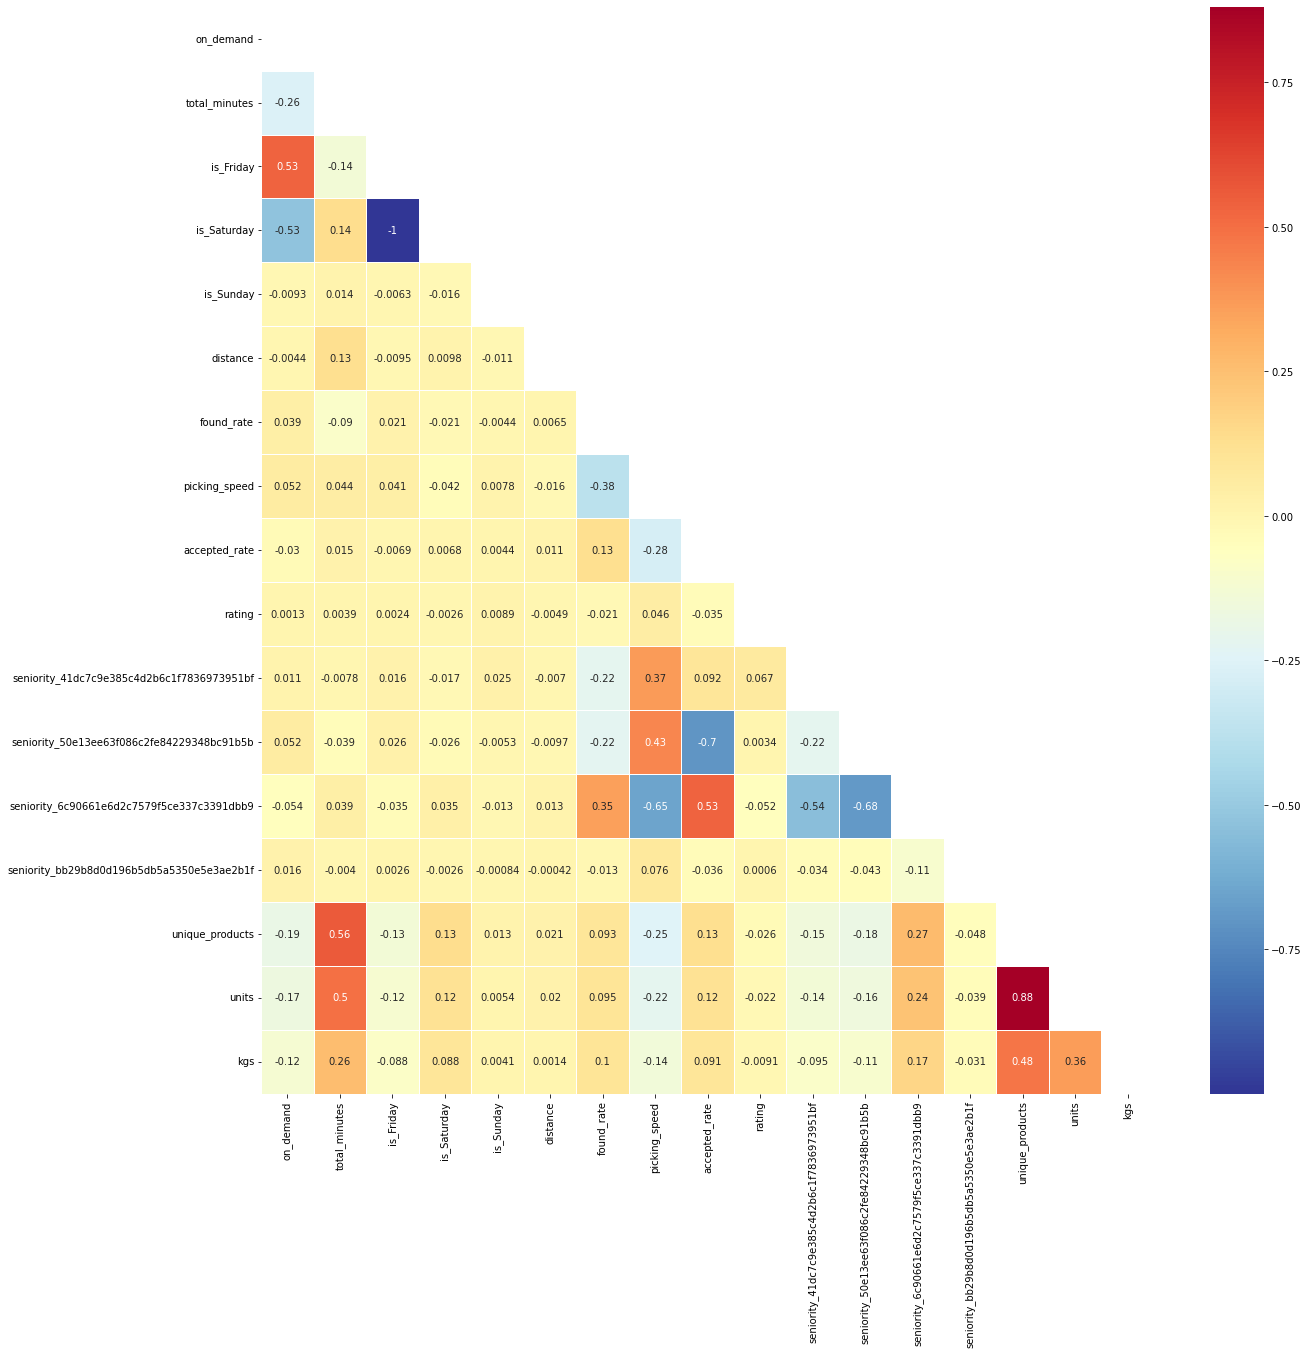

In [41]:
# Plot heatmap
plt.figure(figsize=(20, 20))
heatmap(
    data.corr(), annot=True, linewidth=0.8, mask=np.triu(data.corr()), cmap="RdYlBu_r"
)


unique_products, units and kgs are the features that have greater correlation with total_minutes.

so we create the following features:


In [42]:
# create estimated order size assuming 1 kg is 1 unit
data["order_size"] = data.units + data.kgs

# scale most correlated features with math functions
data["root_order_size"] = np.sqrt(data.order_size)
data["sqrd_order_size"] = data.order_size ** 2
data["logn_order_size"] = np.log(data.order_size)

data["root_units"] = np.sqrt(data.units)
data["sqrd_units"] = data.units ** 2
data["logn_units"] = np.log(data.units + 1)

data["root_kgs"] = np.sqrt(data.kgs)
data["sqrd_kgs"] = data.kgs ** 2
data["logn_kgs"] = np.log(data.kgs + 1)

data["root_unique_products"] = np.sqrt(data.unique_products)
data["sqrd_unique_products"] = data.unique_products ** 2
data["logn_unique_products"] = np.log(data.unique_products)

# Create different rates with distance as it has more correlation than other features
data["distance_div_units"] = np.true_divide(data.distance, data.units + 1)
data["distance_div_kgs"] = np.true_divide(data.distance, data.kgs + 1)
data["distance_div_unique_products"] = data.distance / data.unique_products
data["distance_div_order_size"] = data.distance / data.order_size

# Create different rates with diferent amounts and picking speed that make a sense of time.
data["unique_products_div_picking_speed"] = data.unique_products / data.picking_speed
# For example we are dividing products by products/minute and we end up with minutes.

data["units_div_picking_speed"] = data.units / data.picking_speed
data["kgs_div_picking_speed"] = data.kgs / data.picking_speed
data["order_size_div_picking_speed"] = data.order_size / data.picking_speed


<AxesSubplot:>

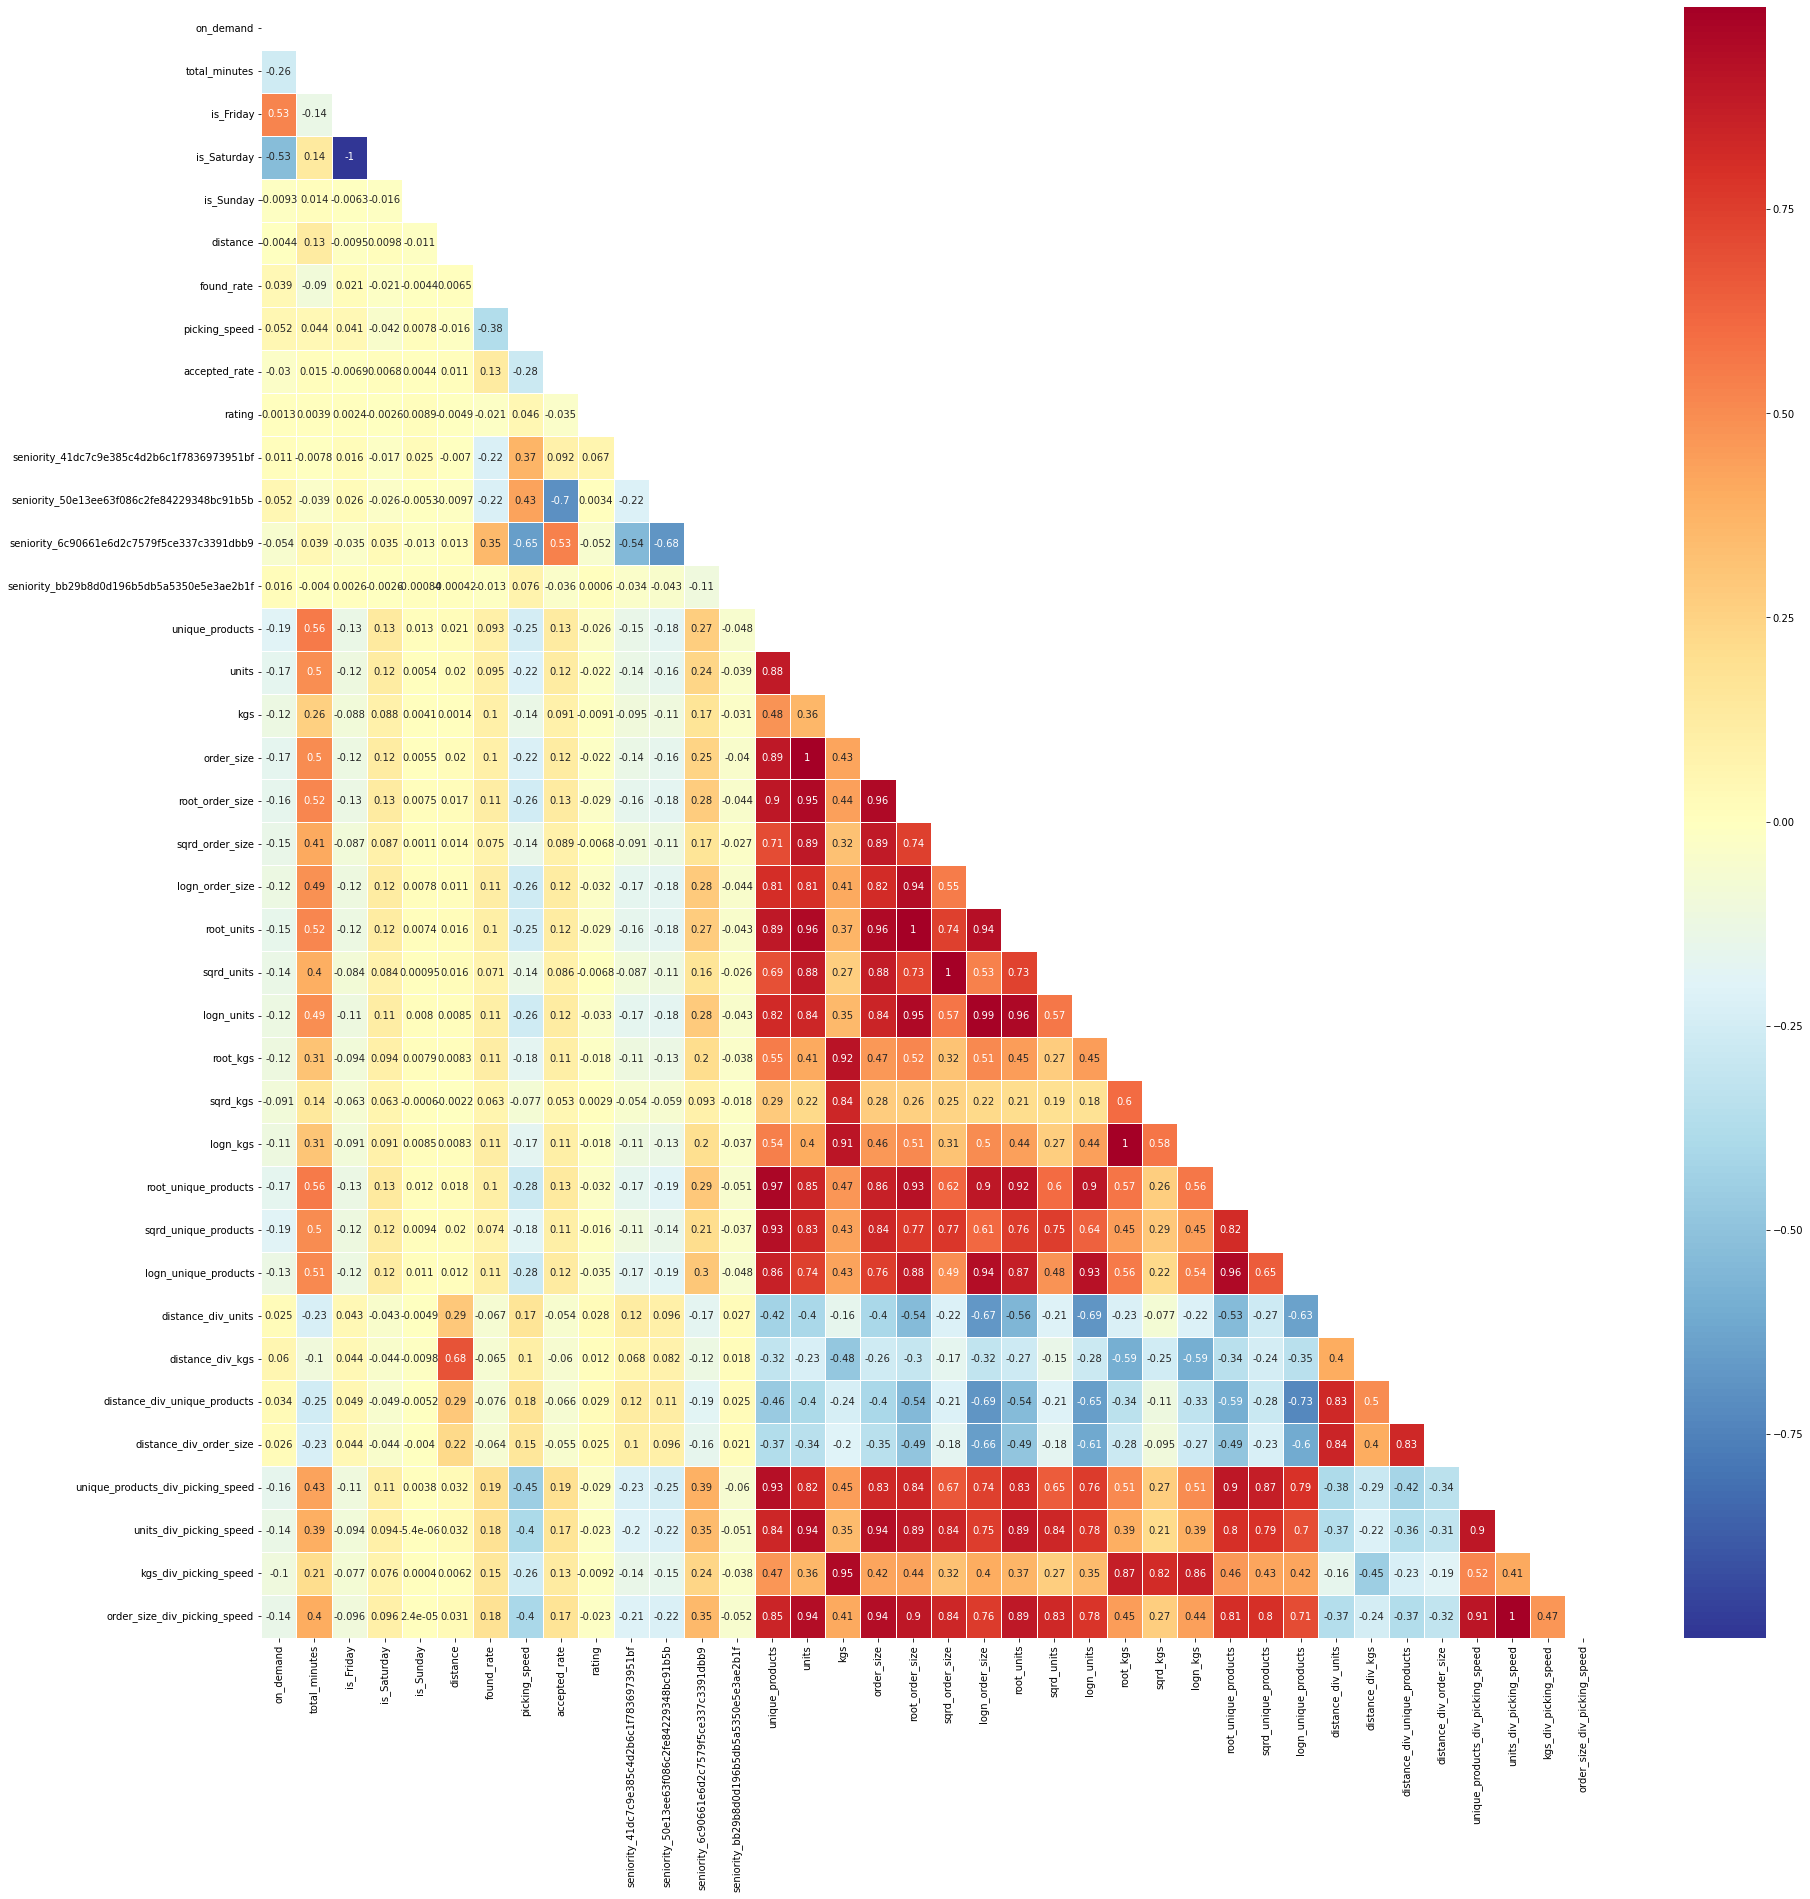

In [43]:
# plot the heatmap again to see the correlation of the newly added features
plt.figure(figsize=(30, 30))
heatmap(
    data.corr(), annot=True, linewidth=0.8, mask=np.triu(data.corr()), cmap="RdYlBu_r"
)


In [44]:
# Show data.min and data.max to see if there are some undefined values
data.min(), data.max()

(on_demand                                      0.000000
 total_minutes                                 11.969489
 is_Friday                                      0.000000
 is_Saturday                                    0.000000
 is_Sunday                                      0.000000
 distance                                       0.076566
 found_rate                                     0.737300
 picking_speed                                  0.650000
 accepted_rate                                  0.240000
 rating                                         3.880000
 seniority_41dc7c9e385c4d2b6c1f7836973951bf     0.000000
 seniority_50e13ee63f086c2fe84229348bc91b5b     0.000000
 seniority_6c90661e6d2c7579f5ce337c3391dbb9     0.000000
 seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f     0.000000
 unique_products                                1.000000
 units                                          0.000000
 kgs                                            0.000000
 order_size                    

no undefined values are found

## Split NaN for later submission

In [45]:
submission = data[pd.isna(data['total_minutes'])]
data.dropna(inplace=True)
data.shape, submission.shape


((7583, 38), (1995, 38))

## Write csv

In [ ]:
# Save data and submission to disk
data.to_csv('data.csv')
submission.to_csv('submission_data.csv')